# Problema de negócio

**Análise de vendas de filiais de lojas de supermercado**

Analisando as vendas das lojas e sua dependência da área das lojas e da contagem diária de clientes

**Contexto**

Um supermercado é uma loja de autoatendimento que oferece uma grande variedade de alimentos, bebidas e produtos domésticos, organizados em seções. Esse tipo de loja é maior e tem uma seleção mais ampla do que as mercearias anteriores, mas é menor e mais limitada na variedade de mercadorias do que um hipermercado ou um grande mercado. No uso diário dos EUA, no entanto, "mercearia" é sinônimo de supermercado e não é usado para se referir a outros tipos de lojas que vendem mantimentos.

[https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount](https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data?datasetId=2133850&sortBy=voteCount)

**Como o problema é resolvido atualmente ?**

    Os analistas de negócio usam a média das últimas vendas para estimar as próximas nas filiais em destaque.

    Baseline = Média das últimas vendas

    Deve-se calcular o erro que a atual solução traz e o seu custo financeiro

    Alavancas ( aumento de vendas, redução de stockout, redução de custos, aumento de faturamento, previsão de demanda)

# Entendimento dos dados

No conjunto de dados, você obterá dados de diferentes lojas de uma empresa de supermercado de acordo com seus IDs de loja que, para facilitar, foram convertidos em números inteiros positivos.

**ID da loja:** (Índice) ID da loja específica.

**Store_Area:** Área Física da loja em metro quadrado.

**Items_Available:** Número de diferentes itens disponíveis na loja correspondente.

**Daily_Customer_Count:** número de clientes que visitaram as lojas em média ao longo do mês.

**Store_Sales:** Vendas em (US$) que as lojas realizaram.

# Bibliotecas

In [60]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from matplotlib import pyplot as plt 
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import  Pipeline, make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, Lasso

from lightgbm import LGBMRegressor as lgb
from xgboost import XGBRegressor as xgb
from catboost import CatBoostRegressor as ctb

from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot


import mlflow
import mlflow.sklearn
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import os

# Separação dos dados

 - Separar treino e teste
 - A amostra de teste será a base de cálculo do ROI 
 - Para calcular o ROI o baseline será a média de vendas por filial simulando a forma como os analistas de negócio estimam as vendas da rede de supermercados

In [2]:
path = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\raw\Stores.csv'

data = pd.read_csv(path, sep=';')

In [3]:
data.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [4]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

In [5]:
train.shape

(716, 5)

In [6]:
test.shape

(180, 5)

In [7]:
# ETL interim
#train.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv',index=False)
#test.to_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv',index=False)

# EDA 
 - Na amostra de treino apenas
 - O teste não será visto pois é para simular o ambiente em produção

In [8]:
df_train = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\train.csv', sep=',')

In [9]:
df_train.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,737,1098,1309,860,59530
1,383,1454,1737,870,23090
2,707,1495,1793,1020,65300
3,818,1608,1962,770,36280
4,119,1500,1798,860,56710


In [10]:
# Sanit check

def sanit_check(df:pd.DataFrame):

    print(f'Número de linhas: {df.shape[0]} \n')
    print(f'Número de colunas {df.shape[1]} \n')
    print(f'Número de linhas duplicadas: {df.duplicated().sum()}\n')
    print(f'Número de linhas nulas:\n {df.isnull().sum()}')

    return None

In [11]:
sanit_check(df_train)

Número de linhas: 716 

Número de colunas 5 

Número de linhas duplicadas: 0

Número de linhas nulas:
 Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64


Não há dados duplicados ou nulos !

<Axes: >

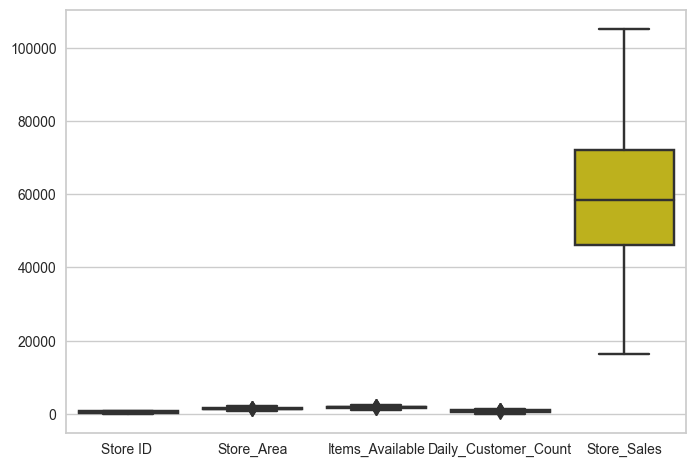

In [12]:
# Check outliers
sns.boxplot(df_train)

Aparentemente não temos outliers nos dados de treino

In [13]:
df_train.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,716.000000,716.000000,716.000000,716.000000,716.000000
mean,450.437151,1482.632682,1778.560056,785.237430,59170.377095
std,257.862012,251.766360,301.446876,259.725136,17357.070464
min,1.000000,775.000000,932.000000,70.000000,16370.000000
25%,225.750000,1315.500000,1571.000000,610.000000,46190.000000
50%,456.500000,1472.000000,1763.000000,770.000000,58385.000000
75%,675.500000,1648.250000,1981.250000,950.000000,72127.500000
max,896.000000,2229.000000,2667.000000,1560.000000,105150.000000


Achados da descritiva acima:

    - Store_Area, Items_Available,	Daily_Customer_Count têm um leve desvio padrão considerando a distância entre os valores máximos e minimos destas variáveis
    - Store_Sales tem um desvio padrão maior, acredito que esta target não tenha uma distribuição normal deve-se testar esta hipótese mais tarde
    - A venda máxima diária foi de $ 105.150,00 e a minima de $ 16.370,00

# Hipóteses de negócio

### 1 - Quanto maior a área física da loja maior as vendas !

<Axes: xlabel='Store_Area', ylabel='Store_Sales'>

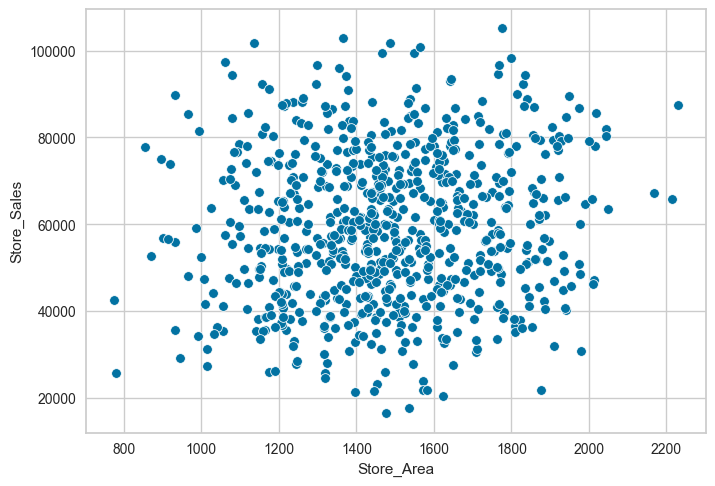

In [14]:
sns.scatterplot(x=df_train['Store_Area'], y=df_train['Store_Sales'])

- Analisando o gráfico aparenta ser falsa esta hipótese, não vejo uma relação linear forte entre os dados

- As maiores vendas se concetram em lojas com 1200 a 1800 metros quadrados

In [15]:
# Testar a H0 de que há uma correlação linear entre a área física da loja e as vendas. 
from scipy.stats import pearsonr

In [16]:
corr, p_value = pearsonr(df_train['Store_Area'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.09928637110096922
Valor p: 0.007845391240498711


O valor p correspondente testa a hipótese nula de que não há correlação linear entre as duas variáveis. Se o valor p for menor que um nível de significância pré-definido (por exemplo, 0,05), isso indica que a hipótese nula pode ser rejeitada em favor da hipótese alternativa de que há uma correlação linear significativa entre as duas variáveis. O valor da correlação indica a direção e a magnitude da relação, ou seja, quanto maior a área física da loja, maior as vendas, mantidas as outras variáveis constantes.

H0 aceita ! Lembrando que correlação não é causalidade

### 2 - Quanto mais itens disponíveis na loja maior as vendas !

<Axes: xlabel='Items_Available', ylabel='Store_Sales'>

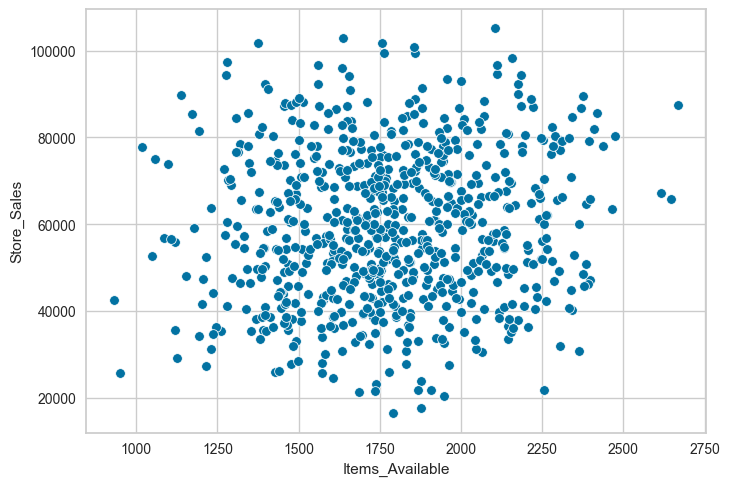

In [17]:
sns.scatterplot(x=df_train['Items_Available'], y=df_train['Store_Sales'])

- Os dados estão bastante dispersos também não há uma forte correlação entre a quantidade de itens para avaliação e o valor de vendas
- Os maiores valores de vendas se concetram na quantidade de itens para avaliação entre 1250 e 2250.

In [18]:
corr, p_value = pearsonr(df_train['Items_Available'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: 0.10009049620048739
Valor p: 0.007355773008398902


H0 aceita ! Hipótese verdadeira.

### 3 - Quanto mais visitas na loja maior as vendas !

<Axes: xlabel='Daily_Customer_Count', ylabel='Store_Sales'>

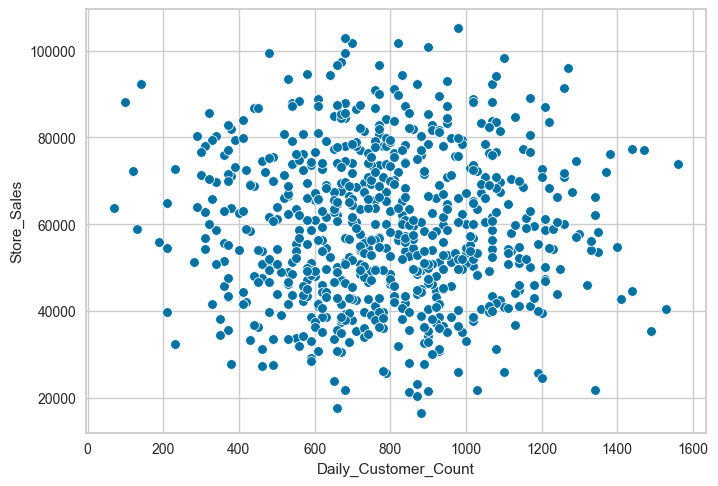

In [19]:
sns.scatterplot(x=df_train['Daily_Customer_Count'], y=df_train['Store_Sales'])

- Pelo gráfico tambem não temos uma forte correlação entre as variáveis
- Os maiores valores de vendas se concetram entre 600 e 1000 visitantes nas lojas

In [20]:
corr, p_value = pearsonr(df_train['Daily_Customer_Count'], df_train['Store_Sales'])
print('Correlação:', corr)
print('Valor p:', p_value)

Correlação: -0.01391553868890451
Valor p: 0.7100999525203255


H0 rejeitada ! Há uma correlação negativa entre as variáveis, quanto maior o número de visitantes menor é o valor de vendas.

    - Deve-se investigar o porquê e a causa, pois há um viés em pensarmos que quanto mais visitantes maiores as chances de compra, porém não é isto que oconteceu.
    - Será que quanto maior o número de visitantes pior é o atendimento ? Ou os clientes não gostam de esperar demais nas filas ? Deve-se investigar no campo !

# Análise Multivariada

In [21]:
# Verificar a correlação entre todas as variáveis 
corr = df_train.corr()

corr.style.background_gradient(cmap= 'coolwarm')

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,1.000000,-0.090003,-0.086335,0.012928,0.079532
Store_Area,-0.090003,1.000000,0.998919,-0.050314,0.099286
Items_Available,-0.086335,0.998919,1.000000,-0.051089,0.100090
Daily_Customer_Count,0.012928,-0.050314,-0.051089,1.000000,-0.013916
Store_Sales,0.079532,0.099286,0.100090,-0.013916,1.000000


# Análise bivariada

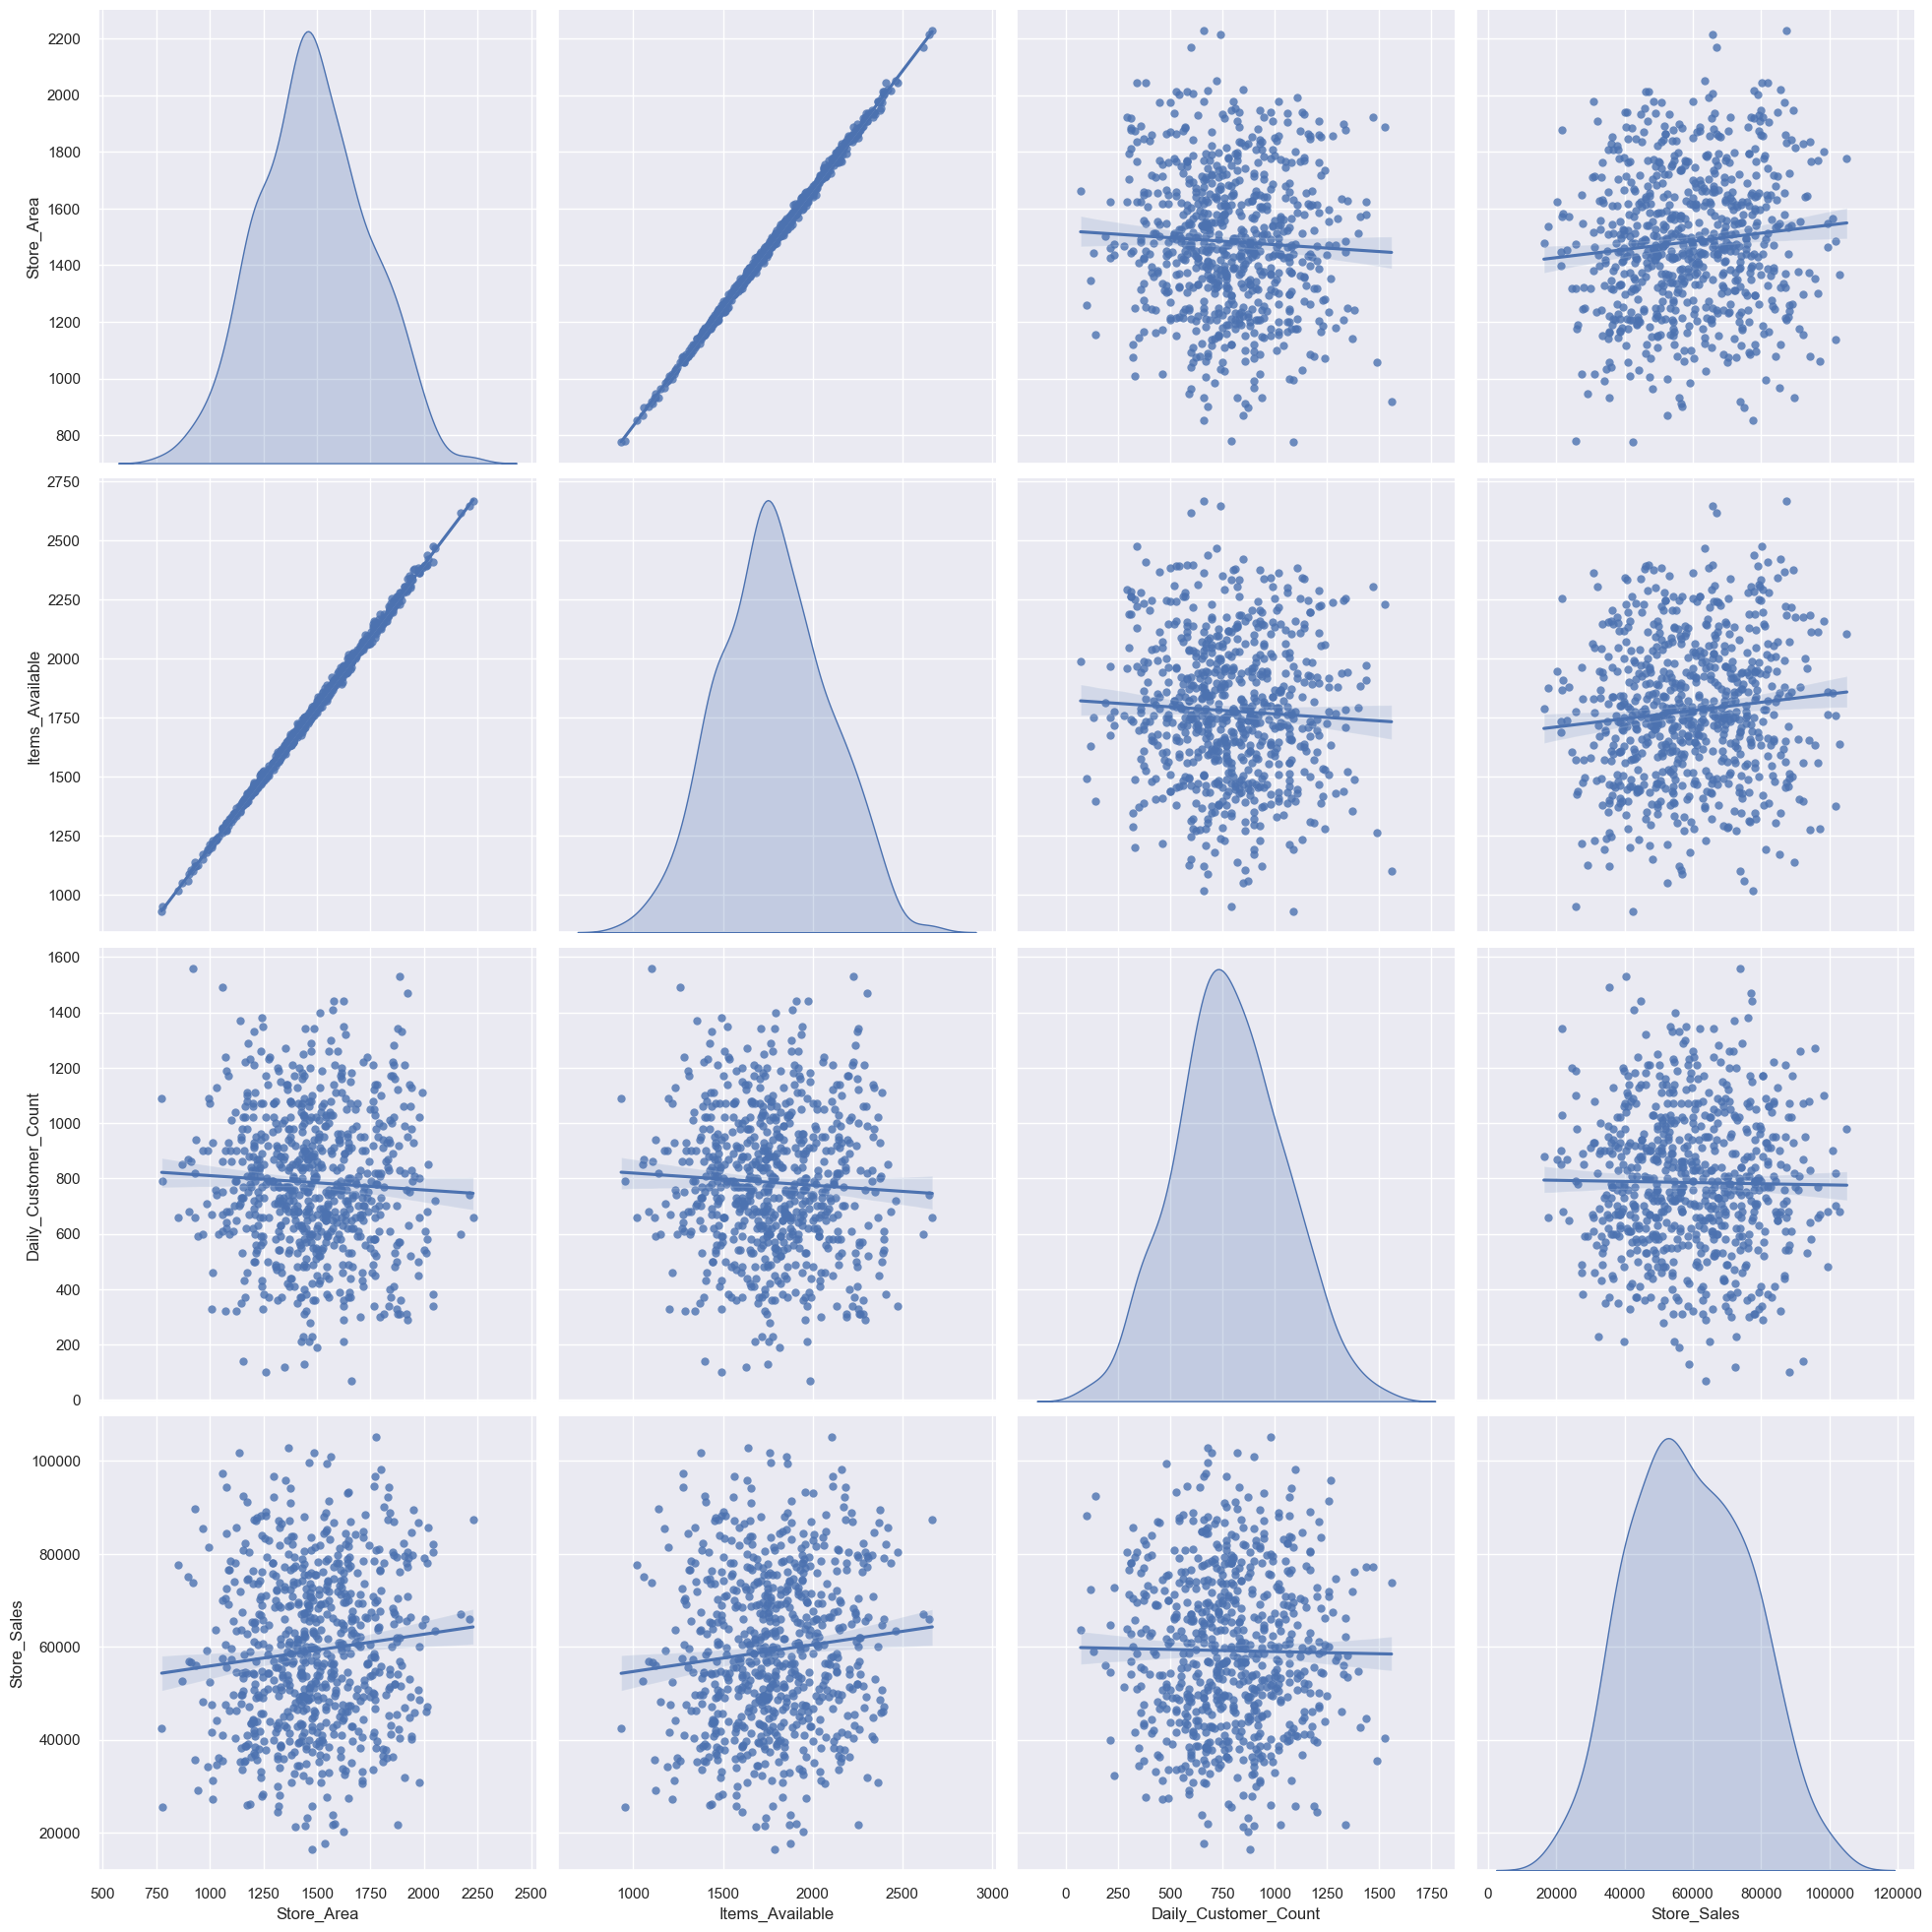

In [22]:
sns.set()
sns.pairplot(df_train.iloc[:,[1,2,3,4]],height = 5 ,kind ='reg',diag_kind='kde')
plt.show()

- A uma forte correlação entre Store_Area e Items_Available
- A correlações positivas fracas entre as variáveis Store_Area e Items_Available com a target Store_Sales

Dito isto será um desafio montar um modelo linear que consiga bons resultados com estas variáveis.

# Análise Univariada

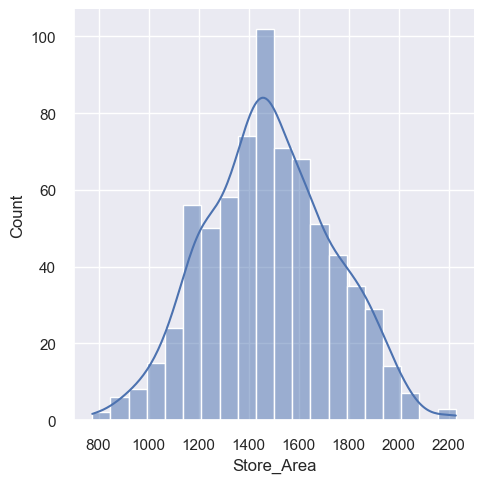

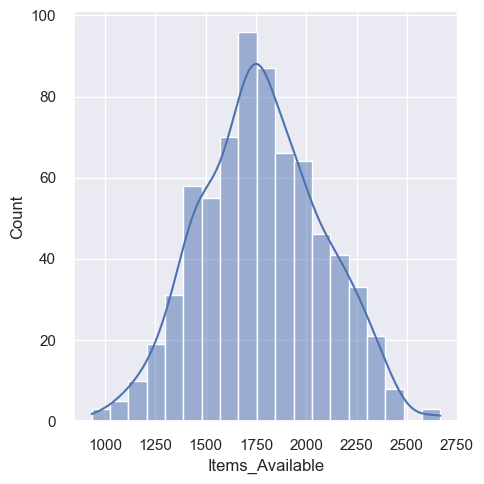

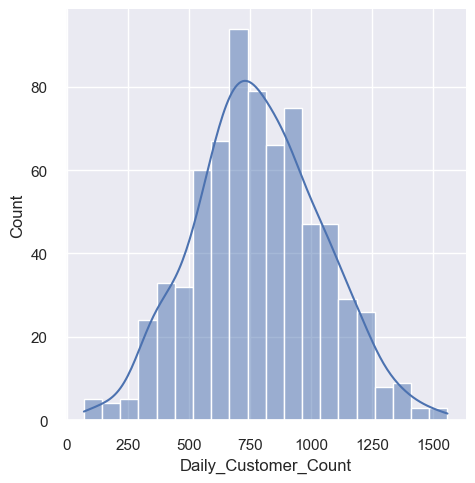

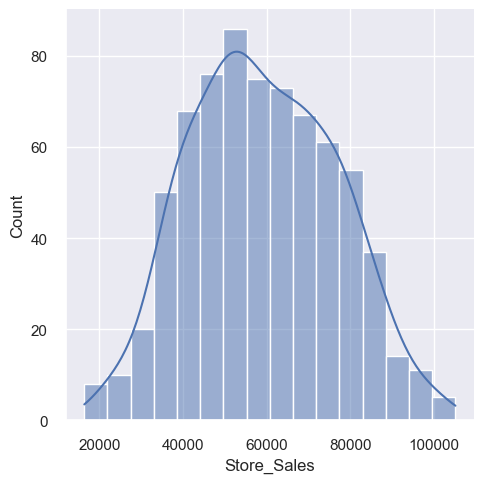

In [23]:
for col in df_train.iloc[:,[1,2,3,4]].columns.to_list():

    sns.displot(df_train[col], kde=True)

- Os gráficos apresentam as variáveis com as distribuições de dados em formato de sino, mas não tenho certeza se elas têm uma distribuição normal, para validar a premissa dos modelos lineares.
- Vou fazer alguns testes de hipóteses nestas variáveis para ter certeza !

In [24]:
from scipy import stats

In [25]:
def test_norm(data: pd.DataFrame):
    for col in data.columns:
        stat, p = stats.shapiro(data[col])
        print(f'Coluna {col}: Estatística de teste = {stat:.3f}, p-valor = {p:.3f}')

        if p > 0.05:
            print(f'Os dados da coluna {col} têm distribuição normal.')
        else:
            print(f'Os dados da coluna {col} não têm distribuição normal.')

In [26]:
test_norm(df_train.iloc[:,[1,2,3,4]])

Coluna Store_Area: Estatística de teste = 0.997, p-valor = 0.139
Os dados da coluna Store_Area têm distribuição normal.
Coluna Items_Available: Estatística de teste = 0.997, p-valor = 0.157
Os dados da coluna Items_Available têm distribuição normal.
Coluna Daily_Customer_Count: Estatística de teste = 0.998, p-valor = 0.390
Os dados da coluna Daily_Customer_Count têm distribuição normal.
Coluna Store_Sales: Estatística de teste = 0.992, p-valor = 0.001
Os dados da coluna Store_Sales não têm distribuição normal.


Por não termos uma distribuiçõ normal na target talvez precisaremos alterar sua natureza para facilitar a previsão dos algoritmos ou usar modelos robustos para estes tipos de dados 

# Baseline de média dos analistas nos dados de teste

In [27]:
# teste
df_teste = pd.read_csv(r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\data\interim\test.csv', sep=',')

In [28]:
# Modelo  de média

# Calcular média de vendas 
mean_sales = np.mean(df_teste['Store_Sales'])

In [29]:
# Prever a média de vendas para cada loja
predictions = np.full(len(df_teste), mean_sales)

In [30]:
# Calcular erro baseline MAE RMSE MAPE

R2 = r2_score(df_teste['Store_Sales'], predictions) 
RMSE = np.sqrt(mean_squared_error(df_teste['Store_Sales'], predictions))
MAPE = mean_absolute_percentage_error(df_teste['Store_Sales'], predictions)

In [31]:
print(f"R2: {R2:.2f}")
print(f"RMSE: {RMSE:.2f}")
print(f"MAPE: {MAPE:.2%}")

R2: 0.00
RMSE: 16493.87
MAPE: 25.74%


    - O modelo de média tem um erro em torno de 25,74% 
    - Nosso objetivo será reduzir este erro

In [32]:
# ML eror
baseline_df = pd.DataFrame(columns=['model','R2', 'RMSE', 'MAPE'])

In [33]:
new_rows = {'model':'Baseline', 'R2':R2, 'RMSE':RMSE, 'MAPE':MAPE}
baseline_df = baseline_df.append(new_rows, ignore_index=True)

In [34]:
baseline_df

,model,R2,RMSE,MAPE
0,Baseline,0.0,16493.874624,0.257367


# Feature Engineering

# Modelagem - Machine Learning

## Treino/Validação

In [35]:
# Separar variáveis independentes e dependente
X = df_train.drop(['Store_Sales'], axis=1)
y = df_train['Store_Sales']

In [36]:
X.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count
0,737,1098,1309,860
1,383,1454,1737,870
2,707,1495,1793,1020
3,818,1608,1962,770
4,119,1500,1798,860


In [37]:
y

0      59530
1      23090
2      65300
3      36280
4      56710
       ...  
711    69310
712    26220
713    48950
714    52060
715    89080
Name: Store_Sales, Length: 716, dtype: int64

In [72]:
# definir função para treinar e validar os modelos e registrar os resultados dos experimentos

def train_validation_eval(model_name, model, X, y, gridsearch=False, params_grid=None, run_name=None, experiment_name=None, path_save_fig=None):
    
    # log nível INFO quando a função começa a ser executada
    print("Função train_validation_eval iniciada")
    
    # listas de métricas para append futuro
    r2 = []
    rmse = []
    mape = []
    
    # inicializar variável best_model e best_param
    best_model = None
    best_param = None
    
    print("Criando DataFrame de comparação do erro")
    # DataFrame de comparação do erro
    models_scores_treino = pd.DataFrame(columns=['model','R2', 'RMSE', 'MAPE'])
    
    
    print("Iniciando loop de validação cruzada")
    # Cross validation
    KFOLD = KFold(n_splits=5, shuffle=True, random_state=42)
    fold = 0 
    
    # Split treino e validação hold out
    for train_ix, val_ix in KFOLD.split(X):
        
        X_train, X_valid = X.iloc[train_ix, :], X.iloc[val_ix, :]
        y_train, y_valid = y.iloc[train_ix], y.iloc[val_ix]
        
        if gridsearch == False:
            print("Treinando modelo com parâmetros padrão")
            # Treino modelo default
            model.fit(X_train, y_train)
            print("Prevendo conjunto de validação com modelo padrão")
            # Prever na validaçã
            yhat = model.predict(X_valid)
            
        else:
            print("Treinando modelo com parâmetros otimizados pelo GridSearch")
            # Definir espaço de gridsearch
            search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error', cv=KFOLD)
            # Ajustar modelo
            search_result = search.fit(X_train, y_train) 
            # melhor parâmetro
            best_param = search_result.best_params_
            # melhor modelo
            best_model = search_result.best_estimator_
            print("Prevendo conjunto de validação com modelo otimizado")
            # Prever na validação com melhor modelo
            yhat = best_model.predict(X_valid)
            
        #Avaliação numerica
        # R2
        R2 = r2_score(y_valid, yhat)
        r2.append(R2)
        # RMSE
        RMSE = np.sqrt(mean_squared_error(y_valid, yhat))
        rmse.append(RMSE)
        # MAPE
        MAPE = mean_absolute_percentage_error(y_valid, yhat)
        mape.append(MAPE)
        
    print("Avaliando resultados nos dados de validação")
    # Avaliação visual erro na reta da regressão
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_valid, y_valid) 
    visualizer.ax.set_facecolor('w')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_prediction_error.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w')
    visualizer.show()
    
    print("-"*30)
    # Avaliação visual resíduos de erro da regressão
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_valid, y_valid)
    visualizer.ax.set_facecolor('w')
    plt.savefig(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"),bbox_inches='tight',transparent=False, format='JPG', facecolor='w') 
    visualizer.show()
    
    print("Salvando resultados no DataFrame de comparação")
    # Adicionar ao DataFrame de comparação
    new_rows = {'model':model_name, 'R2':np.mean(r2), 'RMSE':np.mean(rmse), 'MAPE':np.mean(mape)}
    models_scores_treino = models_scores_treino.append(new_rows, ignore_index=True)
        
    # Avaliação na validação
    print(f"Modelo:  {model_name}")
    print(f"R2 CV:   {np.mean(r2):.2f}")
    print(f"RMSE CV: {np.mean(rmse):.2f}")
    print(f"MAPE CV: {np.mean(mape)*100:.2f}%")
    
    if gridsearch == True:
        # Imprimir melhor parâmetro após o loop de validação cruzada
        print(f"Melhores parâmetros: {best_param}")
    
    
    print("Rastreamento de resultados dos experimentos com MLFLOW iniciado")
    mlflow.set_experiment(experiment_name)
    mlflow.set_tracking_uri('http://127.0.0.1:5000')
    with mlflow.start_run(run_name=run_name):
        if best_param is not None:  
            mlflow.log_params(best_param)
        mlflow.log_metric('R2 CV', np.mean(r2))
        mlflow.log_metric('RMSE CV', np.mean(rmse))
        mlflow.log_metric('MAPE CV', np.mean(mape))
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_prediction_error.jpg"))
        mlflow.log_artifact(os.path.join(path_save_fig,f"{model_name}_residuals.jpg"))
        mlflow.sklearn.log_model(model, model_name)
    mlflow.end_run()
        
    return models_scores_treino


### RandomForestRegressor

In [73]:
# define classe
rfr = RandomForestRegressor(random_state=42)

# define os parâmetros que serão testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [74]:
path_save_fig = r'C:\Users\erico\Documents\projeto-regressao\Supermarket-store-sales-prediction\reports\figures'

Função train_validation_eval iniciada
Criando DataFrame de comparação do erro
Iniciando loop de validação cruzada
Treinando modelo com parâmetros padrão
Prevendo conjunto de validação com modelo padrão
Treinando modelo com parâmetros padrão
Prevendo conjunto de validação com modelo padrão
Treinando modelo com parâmetros padrão
Prevendo conjunto de validação com modelo padrão
Treinando modelo com parâmetros padrão
Prevendo conjunto de validação com modelo padrão
Treinando modelo com parâmetros padrão
Prevendo conjunto de validação com modelo padrão
Avaliando resultados nos dados de validação


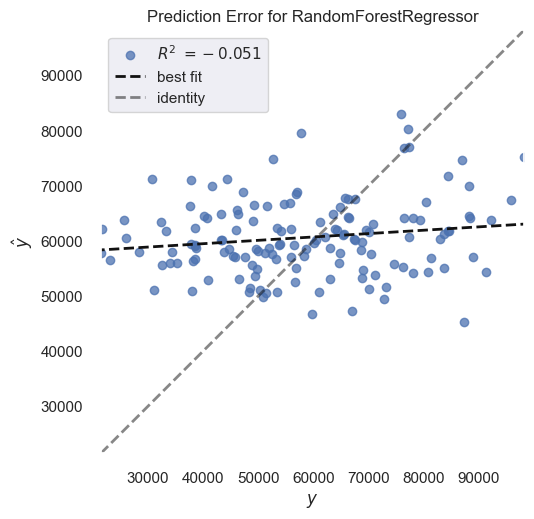

------------------------------


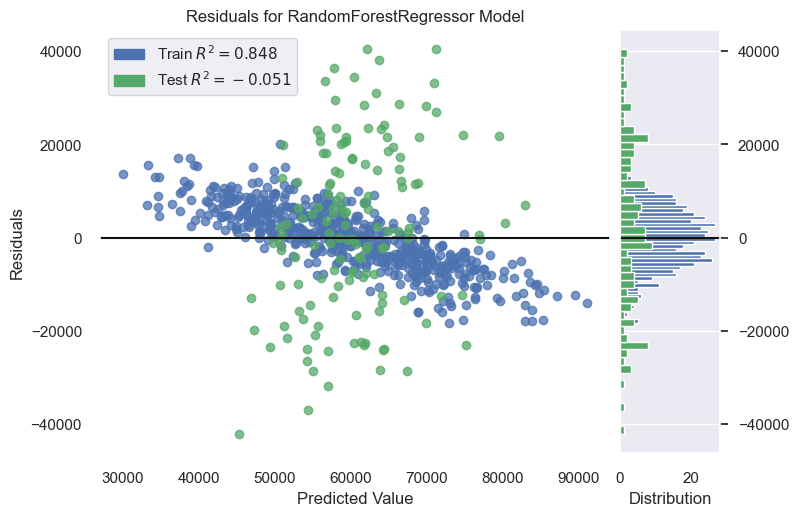

2023/04/08 21:07:46 INFO mlflow.tracking.fluent: Experiment with name 'RandomForestRegressor - 08/04/2023 21:07:43' does not exist. Creating a new experiment.


Salvando resultados no DataFrame de comparação
Modelo:  RandomForestRegressor
R2 CV:   -0.08
RMSE CV: 17943.02
MAPE CV: 29.34%
Rastreamento de resultados dos experimentos com MLFLOW iniciado
CPU times: total: 2.41 s
Wall time: 6.43 s


In [75]:
%%time
# Executar função sem GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
experiment_name = 'RandomForestRegressor'
experiment = experiment_name + ' - ' + date

df_rfr = train_validation_eval('RandomForestRegressor', 
                              rfr, 
                              X, 
                              y, 
                              False,
                              param_grid, 
                              'RandomForestRegressor', 
                              experiment,
                              path_save_fig)

In [71]:
df_rfr

,model,R2,RMSE,MAPE
0,RandomForestRegressor,-0.07943,17943.023711,0.293424


In [ ]:
%%time
# Executar função com GridSearch
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
experiment_name = 'RandomForestRegressor'
experiment = experiment_name + ' - ' + date

df_rfr = train_validation_eval('RandomForestRegressor', 
                              rfr, 
                              X, 
                              y, 
                              True,
                              param_grid, 
                              'RandomForestRegressor', 
                              experiment)

In [ ]:
%%time
# Executar função para modelo com melhores parâmetros encontrados
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
experiment_name = 'RandomForestRegressor'
experiment = experiment_name + ' - ' + date

# Retreinando modelo otimizado com novos hiperparâmetros

rfr_opt = RandomForestRegressor(max_depth=5, min_samples_split=5, random_state=42)

df_rfr = train_validation_eval('RandomForestRegressor', 
                              rfr_opt, 
                              X, 
                              y, 
                              False,
                              param_grid, 
                              'RandomForestRegressor', 
                              experiment)

### LinearRegression

## Teste

In [ ]:
# Separar variáveis independentes e dependente
X_test = df_teste.drop(['Store_Sales'], axis=1)
y_test = df_teste['Store_Sales']

In [ ]:
X_test.head()

In [ ]:
y_test

In [ ]:
# definir função de avaliação para conjunto de teste
def test_eval(model_name, model, X_test, y_test, run_name=None, experiment_name=None):
    
    # DataFrame de comparação do erro no teste
    models_scores_teste = pd.DataFrame(columns=['model','R2', 'RMSE', 'MAPE'])

    # Usar modelo treinado para previsão no conjunto de teste
    yhat = model.predict(X_test)
        
    #Avaliação
    # R2
    R2 = r2_score(y_test, yhat)
    # RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, yhat))
    # MAPE
    MAPE = mean_absolute_percentage_error(y_test, yhat)
        
    # Adicionar ao DataFrame de comparação
    new_rows = {'model':model_name, 'R2':R2, 'RMSE':RMSE, 'MAPE':MAPE}
    models_scores_teste = models_scores_teste.append(new_rows, ignore_index=True)
        
    # Avaliação na validação
    print(f"Modelo: {model_name}")
    print(f"R2: {R2:.2f}")
    print(f"RMSE: {RMSE:.2f}")
    print(f"MAPE: {MAPE:.2%}")
        
    return models_scores_teste
    

### RandomForestRegressor

In [ ]:
%%time
# Executar função para teste 
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
experiment_name = 'RandomForestRegressor_teste'
experiment = experiment_name + ' - ' + date

df_rfr_teste = test_eval('RandomForestRegressor_teste', 
                    rfr_opt, 
                    X_test, 
                    y_test, 
                    'RandomForestRegressor_teste', 
                    experiment)

In [ ]:
df_rfr_teste

# Avaliação - ROI

# Deploy